# Laboratory #10 : Vision Transformers

At the end of this laboratory, you would get familiarized with

*   Vision Transformers

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Vision Transformers

Vision Transformers were introduced by Alexey Dosovitskiy et al. in the paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

Read the ViT paper and answer the below descriptive questions.

*   What are the differences between CNN and Transformers?
*   What is Multi-head self-attention?
*   What is Inductive Bias?

**Solution**

CNNs and Transformers are deep learning architectures with distinct characteristics. CNNs, designed for grid-like data, use convolutional layers for local pattern detection. Transformers, initially for sequences, employ self-attention mechanisms to capture global dependencies. While CNNs operate locally and lack explicit positional modeling, Transformers process entire sequences and require positional embeddings.

Multi-head self-attention is a variant of self-attention where the input is projected multiple times in different, learned representations. The outputs are concatenated and projected again to obtain the final output. This allows the model to jointly attend to information from different representation subspaces at different positions.

Inductive bias is a set of assumptions that a learning algorithm uses to predict outputs given inputs that it has not encountered. Inductive biases are used to prioritize one solution over another, thus reducing the number of solutions that need to be evaluated. In CNNs inductive biases are invariance to translation, equivariance to translation and scale, local connectivity (learning local patterns) and hierarchical feature extraction (higher layers capture more abstract representations). In the case of transformers, these biases are global context awareness, which allows them to consider the whole input sequence before prediction and positional embeddings encoding the position of each element in the sequence.

*   Explain the model architecture of ViT.

**Solution**

The model architecture of ViT is composed by:

- **Patch Extraction**: A sequence of patches are extracted from the original input
- **Linear Projection**: Each patch is converted to high dimensional vectors using MLP or strided convolutions
- **Positional Embedding**: Position of each patch in original image is encoded
- **Stack of encoding blocks**: Equal blocks composed by
  - **Layer Normalization**: It rescales the vector representing the patches to accelerate training (as batch normalization in CNNs)
  - **Multi-head attention layer**: blocks of self-attention providing different representations of the input
  - **Skipped connections**: Improves performance on recognition by propagating representations across layers
  - **Layer Normalization**
  - **2 layer MLP with GELU activation**
- **Dense Classifier Block**: MLP classifier for encoded features

# Introduction

We will implement the Vision Transformer (ViT) model for image classification and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.


## Setup
For this exercise, we require TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview)

In [1]:
pip install -U tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

2023-12-06 20:29:05.683864: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 20:29:05.707998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 20:29:06.073961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode

## Preparing the data

We will use the CIFAR-100 dataset available in tf.keras.datasets package.

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


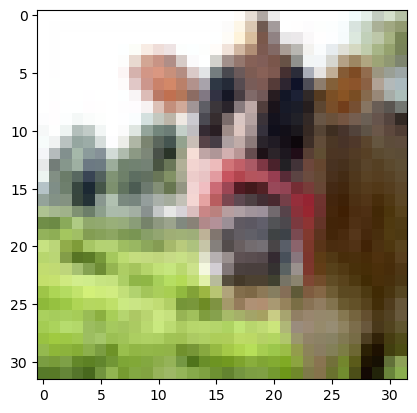

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

## Configure the Hyper-parameters

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 1
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

labels = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"
]

In [6]:
classes = np.unique(y_train)
len(classes)

100

## Data Augmentation Pipeline

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2023-12-06 20:29:07.118859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 20:29:07.135075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 20:29:07.135201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(1, 72, 72, 3)


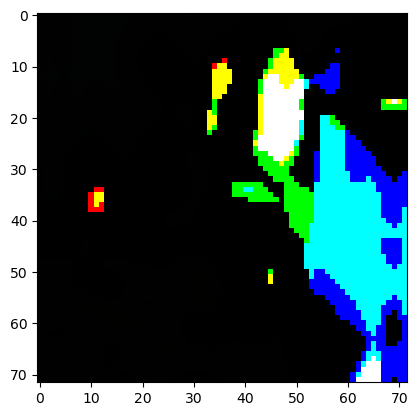

In [8]:
print(data_augmentation(x_train[:1]).shape)

plt.imshow(data_augmentation(x_train[:1])[0].numpy().astype("uint8"))

## Implement a Multi-layer Perceptron (MLP)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implementing Patch Creation Layer

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

### Visualizing the patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


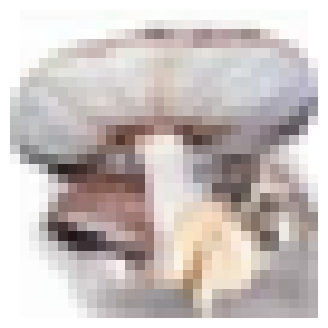

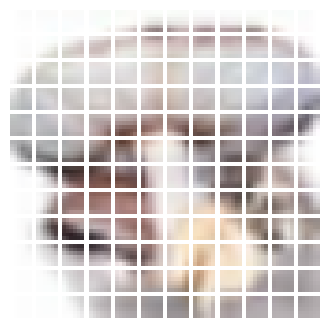

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch Encoding Layer

*   What is the role of Patch Encoding Layer?

**Solution**

Original transformers for NLP receive a sequence of tokens as input. In the case of ViT, the input is a sequence of image patches. The patch encoding layer is responsible for converting the input patches into a sequence of vectors that can be processed by the transformer encoder.The Patch Encoding Layer is essential for adapting the transformer architecture to grid-like data, like images, and is a key component in the success of Vision Transformers in computer vision applications

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

*   What happens in the call function of the PatchEncoder class?

**Solution**

Positions for each patch are encoded using a positional embedding. 

In encoded, linear projection is applied to the patches to obtain a sequence of vectors with the same dimension as the hidden size of the transformer encoder.

Positions are encoded using a positional embedding. The positional embedding is a matrix of size (number of patches + 1, hidden size) that is added to the encoded patches. The additional position is the "CLS" token, which is used as a classifier token in the transformer encoder.

## Building the ViT Model

*   We will use the MultiHeadAttention layer as self-attention for this implementation
*   PS: There are many changes to the original paper for ease of execution

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

*   Explain the execution of the ViT model. What is the sequence of operations?
*   What is skip connection? Why is it needed?

**Solution**



### Execution of the ViT Model:

The execution of the Vision Transformer (ViT) model involves the following sequence of operations:

1. **Input Layer:**
   - The model starts with an input layer that takes images of a specified shape (`input_shape`).

2. **Data Augmentation:**
   - Data augmentation is applied to the input images to enhance the model's ability to generalize by introducing variations in the training data.

3. **Patching:**
   - The augmented images are divided into non-overlapping patches using the `Patches` layer. Each patch is treated as a token.

4. **Patch Encoding:**
   - The `PatchEncoder` layer linearly embeds each patch, creating patch embeddings. Positional encodings are added to convey spatial information.

5. **Transformer Blocks:**
   - Multiple Transformer blocks are iteratively applied to the encoded patches. Each block consists of the following operations:
     - Layer Normalization 1
     - Multi-Head Attention
     - Skip Connection 1
     - Layer Normalization 2
     - Multi-Layer Perceptron (MLP)
     - Skip Connection 2

6. **Global Representation:**
   - The encoded patches are globally represented through layer normalization, flattening, and dropout. This produces a tensor of shape `[batch_size, projection_dim]`.

7. **MLP Head:**
   - An MLP is applied to the global representation to further capture complex relationships and extract high-level features. This step produces a tensor with specified hidden units (`mlp_head_units`).

8. **Classification Output:**
   - The final classification logits are obtained by applying a Dense layer with the number of classes as the output dimension (`num_classes`).

9. **Model Output:**
   - The model outputs the classification logits, which can be used for training and making predictions.

**Skip Connection**:

A skip connection, also known as a residual connection, is a mechanism in neural networks where the input to a layer is added to the output of another layer, forming a skip or shortcut connection. In the ViT model code snippet:

- **Skip Connection 1:**
  - After the multi-head attention operation, the output (`attention_output`) is added to the original encoded patches (`encoded_patches`). This skip connection is represented by `x2 = layers.Add()([attention_output, encoded_patches])`.

- **Skip Connection 2:**
  - After the MLP operation, the output of the MLP (`x3`) is added to the result of the first skip connection (`x2`). This skip connection is represented by `encoded_patches = layers.Add()([x3, x2])`.

The skip connections serve several important purposes in neural networks:

1. **Facilitate Gradient Flow:**
   - Skip connections help in mitigating the vanishing gradient problem during training. By providing a direct path for the gradients, they enable smoother and more efficient gradient flow through the network.

2. **Ease of Training Deep Networks:**
   - Deep networks with many layers can be challenging to train due to issues like vanishing gradients. Skip connections allow for the training of deeper models by making it easier for the model to learn identity mappings.

3. **Enhance Model Expressiveness:**
   - Skip connections enable the network to learn residual mappings, allowing it to focus on learning specific features or details in the data. This can lead to more expressive and effective representations.

4. **Stabilize Training:**
   - The skip connections contribute to the stability of training, making it easier to converge and potentially allowing the use of larger models without encountering training difficulties.

*   What is self-attention?
*   What is the problem in using global self-attention?
*   What can be used instead of global self-attention?

**Solution**

Self-attention, also known as intra-attention, is a mechanism that allows a neural network to focus on different parts of the input sequence when making predictions for a particular element in the sequence. In self-attention, each element in the input sequence computes a weighted sum of all other elements, with the weights determined by their relevance or importance. This allows the model to capture dependencies between different positions in the sequence, enabling it to consider both local and global contextual information.

The problem with global self-attention is that it has a quadratic computational complexity, making it computationally expensive and memory-intensive. 

To address the challenges of global self-attention, a possible alternative is Local Self-Attention. Instead of attending to all elements in the sequence, local self-attention restricts the attention mechanism to a local neighborhood around each position. This reduces the computational complexity and memory requirements while still allowing the model to capture relevant contextual information.

Another alternative is SPT. It spatially shifts an input image in several directions and concatenates them with the input image. Fig. 2(a) is an example of shifting in four diagonal directions. Next, patch partitioning is applied like standard ViTs. Then, for embedding into visual tokens, three processes are sequentially performed: patch flattening, layer normalization and linear projection. As a result, SPT can embed more spatial information into visual tokens and increase the locality inductive bias of ViTs.

## Training the ViT Model

In [14]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [15]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

2023-12-06 20:29:16.123169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - 8s 26ms/step - loss: 3.8519 - accuracy: 0.1182 - top-5-accuracy: 0.3346
Test accuracy: 11.82%
Test top 5 accuracy: 33.46%


### Creating history plots

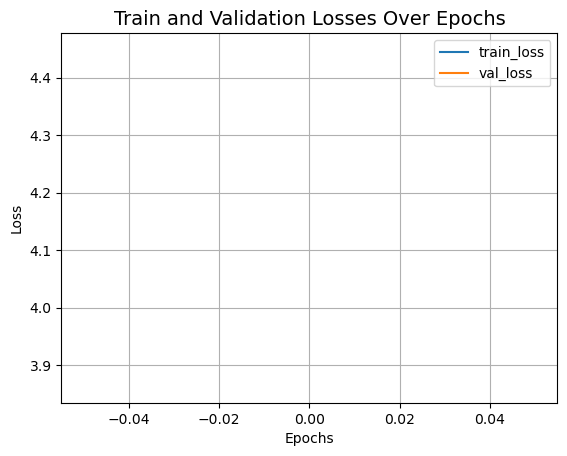

In [16]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

### Evaluating the trained ViT transformer

In [17]:
loss, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 8s 25ms/step - loss: 3.8519 - accuracy: 0.1182 - top-5-accuracy: 0.3346
Test loss: 3.85
Test accuracy: 11.82%
Test top 5 accuracy: 33.46%


# Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are then linearly projected into tokens. Shifted patch tokenization (STP) is introduced to combat the low receptive field of ViTs. The steps for Shifted Patch Tokenization are as follows:
*   Start with an image.
*   Shift the image in diagonal directions.
*   Concat the diagonally shifted images with the original image.
*   Extract patches of the concatenated images.
*   Flatten the spatial dimension of all patches.
*   Layer normalize the flattened patches and then project it.

More details about the implementation can be read from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1)

---
*   Implement a shiftedpatchtokenizer class
*   The class should implement the __init__() and call() functions
*   Implement left-up, right-up, left-down and right-down shift operations


*   Visualize the patches for a random image

ORIGINAL


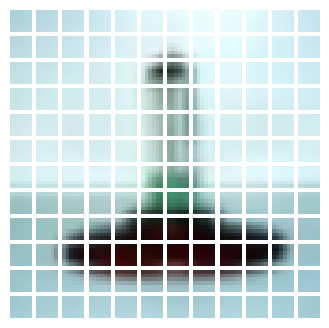

LEFT-UP


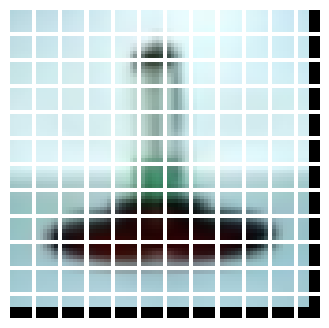

LEFT-DOWN


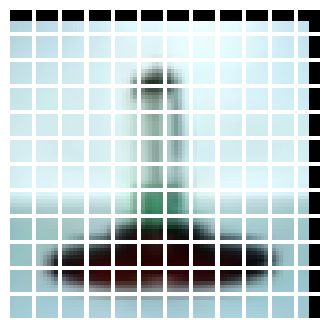

RIGHT-UP


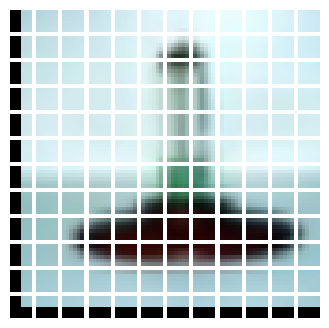

RIGHT-DOWN


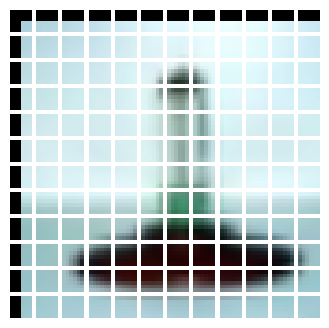

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=num_patches, projection_dim=projection_dim, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches
    
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=image_size,
        patch_size=patch_size,
        num_patches=num_patches,
        projection_dim=projection_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        # Concat the shifted images with the original image
        images = tf.concat(
            [
                images,
                self.crop_shift_pad(images, mode="left-up"),
                self.crop_shift_pad(images, mode="left-down"),
                self.crop_shift_pad(images, mode="right-up"),
                self.crop_shift_pad(images, mode="right-down"),
            ],
            axis=-1,
        )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        flat_patches = self.flatten_patches(patches)

        # Layer normalize the flat patches and linearly project it
        # tokens = self.layer_norm(flat_patches)
        tokens = self.projection(flat_patches)

        return (tokens, patches)


"""
### Visualize the patches
"""

# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)


# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization()(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (patch_size, patch_size, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()


## Build the ViT model

*   Create the ViT classifier by replacing the Patch Layer with the Shifted Patch Layer

In [25]:

def create_spt_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    tokens, patches = ShiftedPatchTokenization()(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


*   Compile and train the classifier

In [26]:
vit_spt_classifier = create_spt_vit_classifier()
history_spt = run_experiment(vit_spt_classifier)

313/313 [==============================] - 6s 20ms/step - loss: 3.8982 - accuracy: 0.1128 - top-5-accuracy: 0.3277
Test accuracy: 11.28%
Test top 5 accuracy: 32.77%


*   Create the history plot for the new ViT model
*   Evaluate the model using the test set

In [ ]:
# solution

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

*   Compute confusion matrix and classification summary of both the models
*   Compare both the models with respect to the computed metrics

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_vit = np.argmax(vit_classifier.predict(x_test), axis=-1)
y_pred_vit_spt = np.argmax(vit_spt_classifier.predict(x_test), axis=-1)

313/313 [==============================] - 6s 19ms/step


In [28]:

print("VIT Classification Report")
print(classification_report(y_test, y_pred_vit, target_names=labels, zero_division=0))

VIT Classification Report
               precision    recall  f1-score   support

        apple       0.18      0.16      0.17       100
aquarium_fish       0.07      0.01      0.02       100
         baby       0.06      0.14      0.08       100
         bear       0.03      0.01      0.02       100
       beaver       0.04      0.03      0.03       100
          bed       0.25      0.01      0.02       100
          bee       0.14      0.09      0.11       100
       beetle       0.10      0.03      0.05       100
      bicycle       0.06      0.02      0.03       100
       bottle       0.00      0.00      0.00       100
         bowl       0.00      0.00      0.00       100
          boy       0.03      0.01      0.02       100
       bridge       0.18      0.09      0.12       100
          bus       0.00      0.00      0.00       100
    butterfly       0.05      0.01      0.02       100
        camel       0.00      0.00      0.00       100
          can       0.04      0.01    

In [29]:

print("DeiT Classification Report")
print(classification_report(y_test, y_pred_vit_spt, target_names=labels, zero_division=0))

DeiT Classification Report
               precision    recall  f1-score   support

        apple       0.19      0.20      0.19       100
aquarium_fish       0.16      0.09      0.11       100
         baby       0.05      0.20      0.07       100
         bear       0.07      0.05      0.06       100
       beaver       0.02      0.02      0.02       100
          bed       0.10      0.01      0.02       100
          bee       0.13      0.02      0.03       100
       beetle       0.10      0.18      0.13       100
      bicycle       0.00      0.00      0.00       100
       bottle       0.11      0.12      0.11       100
         bowl       0.00      0.00      0.00       100
          boy       0.00      0.00      0.00       100
       bridge       0.00      0.00      0.00       100
          bus       0.00      0.00      0.00       100
    butterfly       0.04      0.15      0.06       100
        camel       0.00      0.00      0.00       100
          can       0.00      0.00   

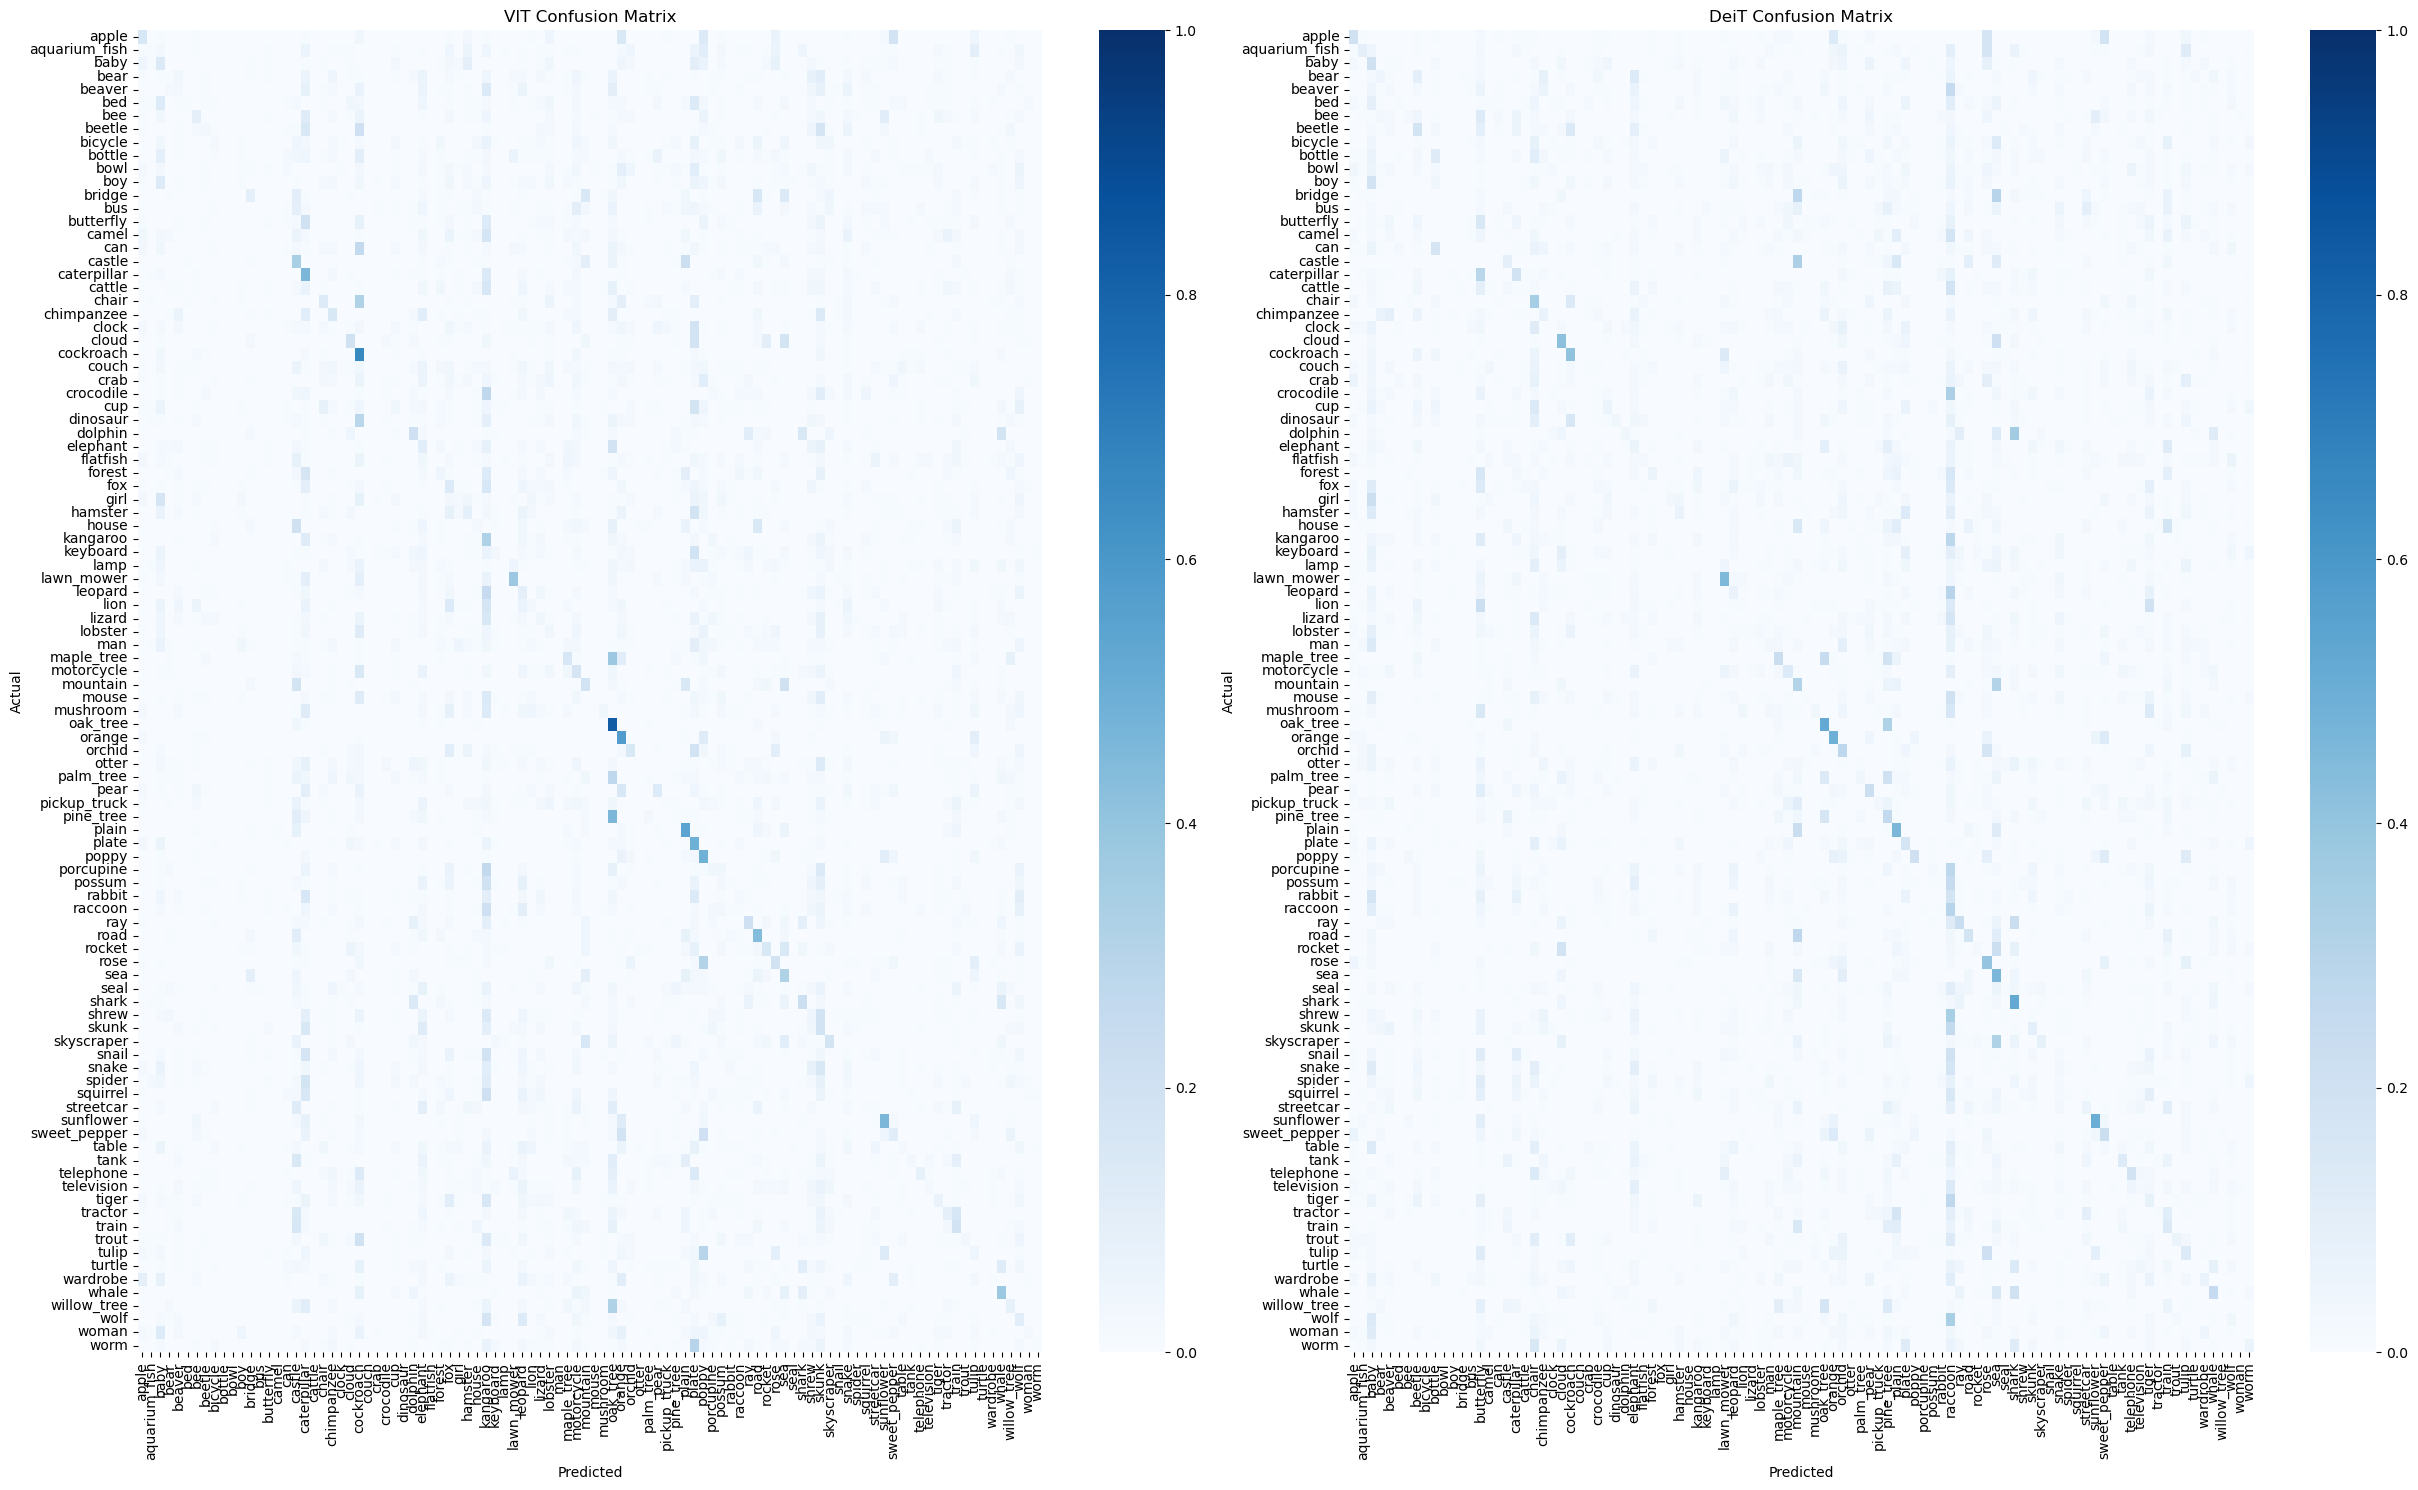

In [38]:
import seaborn as sns
def get_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    return cm

cm_vit = get_confusion_matrix(y_test, y_pred_vit)
cm_vit_spt = get_confusion_matrix(y_test, y_pred_vit_spt)

plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.title("VIT Confusion Matrix")
sns.heatmap(cm_vit, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
plt.title("DeiT Confusion Matrix")
sns.heatmap(cm_vit_spt, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
plt.tight_layout()
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

**Solution**

*(Double-click or enter to edit)*

...

*   Compare DeiT with ViT. 
*   What are the differences in both the architectures.
*   What is one limitation of ViT that is overcome with a DeiT?

**Solution**

Vision Transformer, or ViT, emerged as a pioneering architecture for image classification. It breaks down images into non-overlapping patches and processes them through a transformer network. However, ViT typically demands substantial labeled data for training, often relying on pre-training without distillation.

Data-efficient image Transformer, or DeiT, building upon ViT's foundation but with a focus on overcoming its data hunger. DeiT introduces a novel approach - knowledge distillation. Instead of starting from scratch on massive datasets like ImageNet, DeiT leverages the knowledge from a pre-trained "teacher" model to instruct a smaller "student" model. This strategy significantly enhances data efficiency.

The key difference lies in their training strategies. ViT often requires extensive labeled data for training, potentially making it impractical in scenarios with limited resources. In contrast, DeiT addresses this limitation by distilling knowledge, making it more suitable for situations where labeled data is scarce.

In essence, while ViT opened new possibilities in image classification, DeiT steps in to make the process more data-efficient through intelligent knowledge distillation. It's a progression that allows us to achieve competitive performance with less labeled data, making these architectures versatile in varying practical applications.

*   What is a SWIN Transformer?
*   How is it different from DeiT and ViT?

**Solution**

In the landscape of computer vision models, the Vision Transformer (ViT) emerged as a notable paradigm by segmenting images into patches. However, its efficacy encountered challenges, particularly with larger images.

Introducing the SWIN Transformer, where "SWIN" denotes "Sliding Window." This architectural innovation addresses the intricacies of large images by adopting a sliding window mechanism. Rather than processing the entire image simultaneously, SWIN Transformer meticulously analyzes smaller portions sequentially. This approach substantially enhances efficiency, especially in the context of expansive visual datasets.

Distinctively, SWIN Transformer incorporates a hierarchical processing strategy. It dissects the image into smaller units, processing them in a layered manner. This hierarchical approach facilitates a more seamless flow of information throughout the image, contributing to enhanced performance.

Comparatively, the Data-efficient image Transformer (DeiT) takes a different route. It prioritizes knowledge distillation, leveraging insights from a pre-trained "teacher" model to augment the learning process of a smaller "student" model. The emphasis here is on optimizing performance with limited labeled data.

In essence, ViT laid the foundation, DeiT refined data efficiency through distillation, and now SWIN Transformer enters the stage with a nuanced approach. It adeptly manages large images with a sliding window, coupled with hierarchical processing. Each model within this trio brings its distinctive strengths, collectively contributing to the evolution of computer vision methodologies.

*   What is distillation?
*   Explain the distillation used in DeiT
*   What is its significance? Why do we need distillation?

**Solution**

Distillation in machine learning refers to the process of transferring knowledge from a larger, more complex model (teacher) to a smaller, more compact model (student). The goal is to enable the student model to capture the essential insights and generalizations learned by the teacher, thus achieving comparable performance but with reduced computational requirements.

In the context of DeiT (Data-efficient image Transformer), distillation is employed as a key training strategy. The process involves training a smaller model, the student, to mimic the behavior and knowledge of a larger, pre-trained model, the teacher. The teacher model has typically undergone extensive training on a large dataset, such as ImageNet.

During the distillation process, the student model is not only tasked with learning to classify images but also with reproducing the teacher model's soft probabilities. These soft probabilities convey the confidence or certainty the teacher model has in its predictions. By incorporating this additional information into the training process, the student model gains a richer understanding of the relationships within the data.

The significance of distillation in DeiT lies in its ability to enhance data efficiency. Traditional methods often require large labeled datasets for training, a resource-intensive process. By distilling knowledge from a pre-trained teacher model, DeiT can achieve competitive performance with substantially less labeled data.

*   Which is better as a teacher model? A transformer based teacher of a CNN based teacher?

**Solution**

The choice between a Transformer-based teacher model and a Convolutional Neural Network (CNN)-based teacher model hinges on task requirements and available resources. Transformers excel in capturing long-range dependencies, making them versatile for tasks requiring a global understanding. However, they can be computationally demanding. On the other hand, CNNs are efficient at capturing local spatial hierarchies, making them suitable for image-related tasks, but they may struggle with long-range dependencies.

The nature of the task is crucial. Tasks requiring a global understanding, such as complex image scenes or sequential data, may benefit from a Transformer-based teacher. For tasks relying heavily on local spatial hierarchies, like image classification, a CNN-based teacher could be more practical.

Considerations also include computational resources. Transformers may demand more computational power, so the choice might depend on available resources. Additionally, the amount of labeled data is a factor. If the dataset is small, a transformer's ability to transfer knowledge may be advantageous.

In essence, the decision should align with task characteristics, computational resources, and data availability. Both architectures have strengths, and the choice should be tailored to the specific requirements of the learning problem.


---

## **End of lab10: Vision Transformers**